In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import hybrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from joblib import Parallel
from dwave.cloud.api import Problems

from dwave.embedding.chain_breaks import majority_vote, broken_chains
import dimod

def unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=False):
    variables = list(bqm.variables)  # need this ordered
    try:
        chains = [embedding[v] for v in variables]
    except KeyError:
        raise ValueError("given bqm does not match the embedding")

    record = sampleset.record

    unembedded, idxs = majority_vote(sampleset, chains)

    reserved = {'sample', 'energy'}
    vectors = {name: record[name][idxs]
            for name in record.dtype.names if name not in reserved}
    
    if chain_break_fraction:
        broken = broken_chains(sampleset, chains)
        if broken.size:
            vectors['chain_break_fraction'] = broken.mean(axis=1)[idxs]
        else:
            vectors['chain_break_fraction'] = 0

    info = sampleset.info.copy()

    return dimod.SampleSet.from_samples_bqm((unembedded, variables),
                                            bqm,
                                            info=info,
                                            **vectors)



### RQ1.1: Embedding Impact - General Case

In [2]:
with open("pickles/RQ1.1_saved_data.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)

acl_ = acl.flatten()
acl_ = acl_[~np.isnan(acl_)]
num_qubits_ = num_qubits.flatten()
num_qubits_ = num_qubits_[~np.isnan(num_qubits_)]
median_relative_errors_= median_relative_errors.flatten()
median_relative_errors_ = median_relative_errors_[~np.isnan(median_relative_errors_)]
median_unembedded_relative_errors_= median_unembedded_relative_errors.flatten()
median_unembedded_relative_errors_ = median_unembedded_relative_errors_[~np.isnan(median_unembedded_relative_errors_)]

data = np.array([median_relative_errors_, acl_])
data = data[:, np.argsort(data[1])]

Coefficients: a = 0.4861509903903699, b = 0.025735090891443973, c = -0.4915985054052235
R-squared: 0.9817937040914162


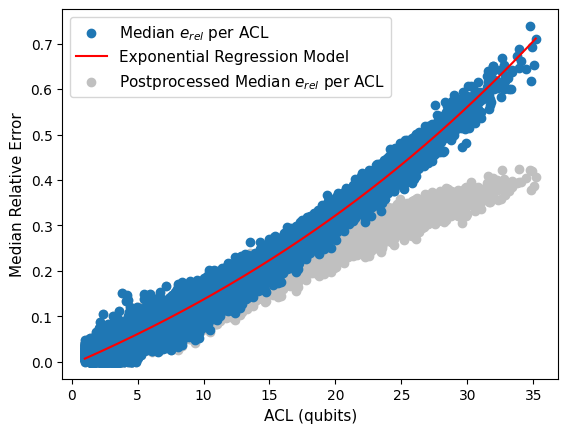

In [3]:
plt.figure()
plt.scatter(acl_, median_unembedded_relative_errors_, label=r'Postprocessed Median $e_{rel}$ per ACL', color='silver')

def exponential_model(n_qubits, a, b, c):
    return a * np.exp(b * n_qubits) + c

acl_ordered_, median_relative_errors_ordered_ = (np.array(t) for t in zip(*sorted(zip(acl_, median_relative_errors_))))

# Fit the exponential model to the data
params, covariance = curve_fit(exponential_model, acl_ordered_, median_relative_errors_ordered_)

# Extract the coefficients
a, b, c = params

# Print the coefficients
print(f"Coefficients: a = {a}, b = {b}, c = {c}")

# Predict values using the fitted model
fitted_values = exponential_model(acl_ordered_, a, b, c)

# Plot the original data and the fitted model

plt.scatter(acl_ordered_, median_relative_errors_ordered_, label=r'Median $e_{rel}$ per ACL')
plt.plot(acl_ordered_, fitted_values, color='red', label='Exponential Regression Model')
plt.xlabel('ACL (qubits)', fontsize=11)
plt.ylabel(r'Median Relative Error', fontsize=11)

# # Calculate the R-squared value
ss_res = np.sum((median_relative_errors_ordered_ - fitted_values) ** 2)
ss_tot = np.sum((median_relative_errors_ordered_ - np.mean(median_relative_errors_ordered_)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Print the R-squared value
print(f"R-squared: {r_squared}")


# Change the order of the legend items
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=11)

# plt.legend(loc='upper right', bbox_to_anchor=(1.97, 1.02))

# plt.savefig('exponential.pdf', format='pdf')
plt.show()

In [4]:
with open("pickles/RQ1.1_saved_data.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)
    container = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)

median_broken_chain_fraction = np.zeros(np.shape(median_relative_errors))
for den in range(20):
    for size in range(16):
        for problem_idx in range(5):
            bqm = container[80*den+5*size+problem_idx][0]
            for embedding_idx in range(10):
                embedding, sampleset, _, _, _, _, _ = container[80*den+5*size+problem_idx][1][embedding_idx]
                if embedding:
                    broken_chain_fraction_list = []
                    for i in unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=True).record:
                        broken_chain_fraction_list.append(i[-1])
                    median_broken_chain_fraction[den, size, problem_idx, embedding_idx] = np.median(broken_chain_fraction_list)
                else:
                    median_broken_chain_fraction[den, size, problem_idx, embedding_idx] = np.nan

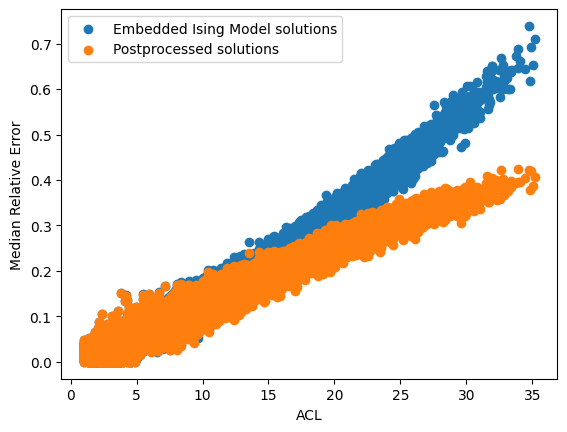

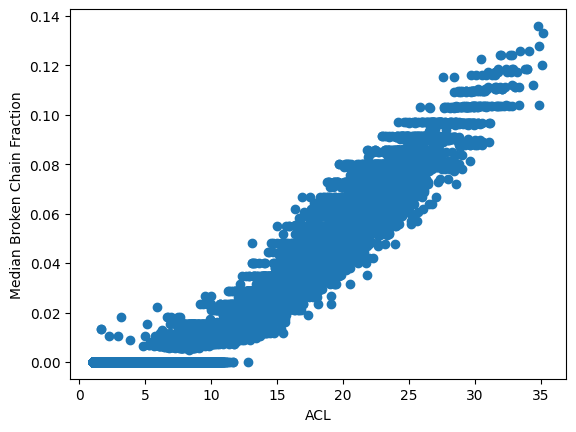

In [5]:
plt.scatter(acl, median_relative_errors, label='Embedded Ising Model solutions')
plt.scatter(acl, median_unembedded_relative_errors, label='Postprocessed solutions')
plt.xlabel('ACL')
plt.ylabel('Median Relative Error')
# plt.title(f'Exponential Model Fit: {round(a,3)}e^({round(b,3)}*ACL){round(c,3)}')
plt.legend()
plt.show()

plt.scatter(acl, median_broken_chain_fraction)
plt.xlabel('ACL')
plt.ylabel('Median Broken Chain Fraction')
plt.show()

### RQ1.2 Embedding Impact - Stressed

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import hybrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import pandas as pd
from dwave.cloud.api import Problems
import json
import time
from scipy.optimize import curve_fit
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors

from dwave.embedding.chain_breaks import majority_vote, broken_chains
import dimod

def unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=False):
    variables = list(bqm.variables)  # need this ordered
    try:
        chains = [embedding[v] for v in variables]
    except KeyError:
        raise ValueError("given bqm does not match the embedding")

    record = sampleset.record

    unembedded, idxs = majority_vote(sampleset, chains)

    reserved = {'sample', 'energy'}
    vectors = {name: record[name][idxs]
            for name in record.dtype.names if name not in reserved}
    
    if chain_break_fraction:
        broken = broken_chains(sampleset, chains)
        if broken.size:
            vectors['chain_break_fraction'] = broken.mean(axis=1)[idxs]
        else:
            vectors['chain_break_fraction'] = 0

    info = sampleset.info.copy()

    return dimod.SampleSet.from_samples_bqm((unembedded, variables),
                                            bqm,
                                            info=info,
                                            **vectors)


ImportError: DLL load failed while importing _univariate_diffuse: El nombre del archivo o la extensión es demasiado largo.

In [ ]:
with open("pickles/RQ1.2_saved_data.pkl.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)


data = np.array([median_relative_errors.flatten(), acl.flatten(), [i for i in range(5) for j in range(100)]])
data = data[:, np.argsort(data[1])]


In [ ]:
plt.scatter(acl, median_relative_errors, label='Embedded Ising Model solutions')
plt.scatter(acl, median_unembedded_relative_errors, label='Postprocessed solutions')
plt.xlabel('ACL')
plt.ylabel('Median Relative Error')
# plt.title(f'Exponential Model Fit: {round(a,3)}e^({round(b,3)}*ACL){round(c,3)}')
plt.legend()

plt.show()

In [ ]:
def exponential_model(n_qubits, a, b, c):
    return a * np.exp(b * n_qubits) + c

# Fit the exponential model to the data
params, covariance = curve_fit(exponential_model, data[1], data[0])

# Extract the coefficients
a, b, c = params

# Print the coefficients
print(f"Coefficients: a = {a}, b = {b}, c = {c}")

# Predict values using the fitted model
fitted_values = exponential_model(data[1], a, b, c)

# Plot the original data and the fitted model
plt.figure()
plt.scatter(data[1], data[0], label='Median relative error per embedding ACL')
plt.plot(data[1], fitted_values, color='red', label='Fitted Exponential Regression Model')
plt.xlabel('ACL')
plt.ylabel('Median Relative Error')
# plt.title(f'Exponential Model Fit: {round(a,3)}e^({round(b,3)}*ACL){round(c,3)}')
plt.legend()
plt.show()


# Calculate the R-squared value
ss_res = np.sum((data[0] - fitted_values) ** 2)
ss_tot = np.sum((data[0] - np.mean(data[0])) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Print the R-squared value
print(f"R-squared: {r_squared}")


In [ ]:
def exponential_model(n_qubits, a, b, c):
    return a * np.exp(b * n_qubits) + c


fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Define the colormap and states
cmap = ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:purple'])
states = np.unique(data[2])      # Should give 5 unique values
colors_list = [cmap(i) for i in range(len(states))]

# First subplot with color-coded scatter
for state, color in zip(states, colors_list):
    mask = data[2] == state
    axes[0].scatter(data[1][mask], data[0][mask], color=color, label=fr'Problem {round(state)+1}')

params, covariance = curve_fit(exponential_model, data[1], data[0])
a, b, c = params
fitted_values = exponential_model(data[1], a, b, c)

# Calculate the R-squared value
ss_res = np.sum((data[0] - fitted_values) ** 2)
ss_tot = np.sum((data[0] - np.mean(data[0])) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared}")

axes[0].plot(data[1], fitted_values, color='red', label='Regression Model')

axes[0].scatter(acl, median_unembedded_relative_errors, label='Postprocessed', color = 'silver')

axes[0].set_title('a) All together', fontsize = 14)
# axes[0].legend(loc='upper right', bbox_to_anchor=(4.3, 1.01))

tit = ["b)", "c)", "d)", "e)", "f)"]

# Other subplots (example placeholder loops)
for i in range(1, 6):

    params, covariance = curve_fit(exponential_model, acl[i-1], median_relative_errors[i-1])
    a, b, c = params
    fitted_values = exponential_model(acl[i-1], a, b, c)

    axes[i].scatter(acl[i-1], median_relative_errors[i-1], color=['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:purple'][i-1])
    axes[i].plot(acl[i-1][np.argsort(acl[i-1])], fitted_values[np.argsort(acl[i-1])], color='red')

    
    axes[i].scatter(acl[i-1], median_unembedded_relative_errors[i-1], color = 'silver')

    axes[i].set_title(f'{tit[i-1]} Problem {i}', fontsize = 14)

    # Calculate the R-squared value
    ss_res = np.sum((median_relative_errors[i-1] - fitted_values) ** 2)
    ss_tot = np.sum((median_relative_errors[i-1] - np.mean(median_relative_errors[i-1])) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R-squared: {r_squared}")

# Shared labels
for ax in axes[3:]:
    ax.set_xlabel('ACL (qubits)', fontsize = 13)

axes[0].set_ylabel('Median Relative Error', fontsize = 13)
axes[3].set_ylabel('Median Relative Error', fontsize = 13)


fig.legend(loc = 1, bbox_to_anchor  = (1.2, 0.965), fontsize = 13)

plt.tight_layout()
plt.savefig("figure_grid.pdf", bbox_inches = 'tight')
plt.show()


In [ ]:
with open("pickles/RQ1.2_saved_data.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)
    container = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)

median_broken_chain_fraction = np.zeros((5, 100))
for problem_idx in range(5):
    bqm = container[problem_idx][0]
    for embedding_idx in range(100):
        embedding, sampleset, _, _, _, _, _ = container[problem_idx][1][embedding_idx]
        broken_chain_fraction_list = []
        for i in unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=True).record:
            broken_chain_fraction_list.append(i[-1])
        median_broken_chain_fraction[problem_idx, embedding_idx] = np.median(broken_chain_fraction_list)
        

In [ ]:
plt.scatter(acl, median_relative_errors, label='Embedded Ising Model solutions')
plt.scatter(acl, median_unembedded_relative_errors, label='Postprocessed solutions')
plt.xlabel('ACL')
plt.ylabel('Min Relative Error')
# plt.title(f'Exponential Model Fit: {round(a,3)}e^({round(b,3)}*ACL){round(c,3)}')
plt.legend()
plt.show()

plt.scatter(acl, median_broken_chain_fraction)
plt.xlabel('ACL')
plt.ylabel('Min Broken Chain Fraction')
plt.show()

In [ ]:
with open("pickles/RQ1.2_saved_data.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors] = pickle.load(f)
    container = pickle.load(f)

median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)

min_relative_errors = np.min(relative_errors, axis = -1)
min_unembedded_relative_errors = np.min(unembedded_relative_errors, axis = -1)

median_broken_chain_fraction = np.zeros((5, 100))
min_broken_chain_fraction = np.zeros((5, 100))
for problem_idx in range(5):
    bqm = container[problem_idx][0]
    for embedding_idx in range(100):
        embedding, sampleset, _, _, _, _, _ = container[problem_idx][1][embedding_idx]
        broken_chain_fraction_list = []
        for i in unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=True).record:
            broken_chain_fraction_list.append(i[-1])
        median_broken_chain_fraction[problem_idx, embedding_idx] = np.median(broken_chain_fraction_list)
        min_broken_chain_fraction[problem_idx, embedding_idx] = np.min(broken_chain_fraction_list)
        

In [ ]:
plt.scatter(acl, min_relative_errors, label='Embedded Ising Model solutions')
plt.scatter(acl, min_unembedded_relative_errors, label='Postprocessed solutions')
plt.xlabel('ACL')
plt.ylabel('Median Relative Error')
# plt.title(f'Exponential Model Fit: {round(a,3)}e^({round(b,3)}*ACL){round(c,3)}')
plt.legend()
plt.show()

plt.scatter(acl, min_broken_chain_fraction)
plt.xlabel('ACL')
plt.ylabel('Median Broken Chain Fraction')
plt.show()